**K Nearest Neighbors**

Exercise taken from [Mathematics for Machine Learning: PCA by Imperial College London, Coursera](https://www.coursera.org/learn/pca-machine-learning/)

In this section, we will explore the KNN classification algorithm. A classification algorithm takes input some data and use the data to determine which class (category) this piece of data belongs to.

As a motivating example, consider the [iris flower dataset](https://archive.ics.uci.edu/dataset/53/iris). The dataset consists of 150 data points where each data point is a feature vector $x \in \R^4 $ describing the attribute of a flower in the dataset, the four dimensions represent
1. sepal lenght in cm
2. sepal width in cm
3. petal lenght in cm
4. petal width in cm

And the corresponding target $y \in Z$ describes the class of the flower. It uses the integers $0$, $1$, $2$ to represent the 3 classes of flowers in this dataset.
0. Iris Setosa
1. Iris Versicolour
2. Iris Virginica



**Libraries Description**
* `numpy`: A fundamental package for scientific computing with Python. It provides support for arrays, matrices, and high-level mathematical functions.
* `matplotlib.pyplot`: A plotting library for creating static, interactive, and animated visualizations in Python.
* `datasets`: The datasets module provides utilities to load datasets, including methods to load and fetch popular reference datasets. It is used here to possibly work with example datasets for machine learning tasks.

**Jupyter Notebook-specific commands**
* `%matplotlib inline`: A magic command that allows the output of plotting commands to be displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.
* `%config InlineBackend.figure_format = 'svg'`: Another magic command that configures the inline backend to use SVG (Scalable Vector Graphics) format for figures instead of the default (usually PNG). SVGs are generally clearer than PNGs and can be scaled without loss of quality, which is beneficial for detailed visualizations.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

**Working with the Iris dataset**

Lets load de dataset in a pandas DataFrame object format and check the first rows. Then, check data shape.


In [11]:
iris_df = datasets.load_iris(as_frame=True).frame
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [12]:
print('Data shape:', iris_df.shape)

Data shape: (150, 5)


For the simplicity of the exercise, we will only use the first 2 dimensions (sepal length and sepal width) of as features used to classify the flowers.

In [13]:
X = iris_df.iloc[:, :2]
y = iris_df['target']

iris_classes = ['Iris Setosa', 'Iris Versicolour', 'Iris Virginica']

Let's create a scatter plot of the dataset below. The x and y axis represent the sepal length and sepal width of the dataset, and the color of the points represent the different classes of flowers.

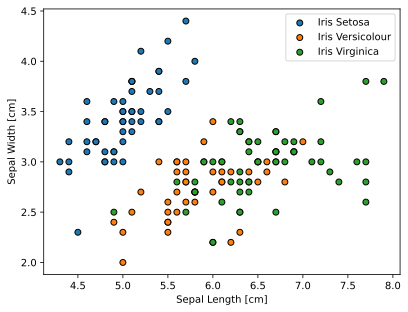

In [14]:
fig, ax = plt.subplots()
for i, iris_class in enumerate(iris_classes):
    ax.scatter(X[y==i].iloc[:, 0], X[y==i].iloc[:, 1], edgecolors='k', label=iris_class)
ax.set(xlabel='Sepal Length [cm]', ylabel='Sepal Width [cm]')
ax.legend()

**Euclidean Distance**

The Euclidean distance between two points _x_ and _y_ in a _D_-dimensional space is defined as
$$d(x, y) = \sqrt{<(x-y),\space (x-y)>}\to\sqrt{\sum_{d=1}^{D} (x_d - y_d)^2}$$

**Generalizing for Matrices _X_ and _Y_**

Defining:
1. _X_ has size _N_ $\times$ _D_.
2. _Y_ has size _M_ $\times$ _D_.

We want to compute the distance matrix _D_ of size _N_ $\times$ _M_ where each entry $D[i,j]$ is the Euclidean distance between row _i_ of _X_ and row _j_ of _Y_.

**Expanding the Distance**

The squared Euclidean distance between two rows $x_i$ and $y_j$ is
$$dist(x_i,y_j)^2=\sum_{d=1}^D (x_{id}-y_{jd})^2\to\sum_{d=1}^D (x^2_{id}+2\cdot x_{id}\cdot y_{id} + y^2_{jd})\to\sum_{d=1}^D (x^2_{id})+\sum_{d=1}^D (2\cdot x_{id}\cdot y_{id}) + \sum_{d=1}^D (y^2_{jd})$$

Where:
* $\sum_{d=1}^D (x^2_{id})$ is the vector of the sum of squares of each row of _X_ ($X_i\cdot X_i^T$) of size _N_ $\times$ 1
* $\sum_{d=1}^D (2\cdot x_{id}\cdot y_{id})$ is the matrix product between $X$ and $Y^T$ ($X_i\cdot Y_j^T$) of size 1 $\times$ _M_
* $\sum_{d=1}^D (y^2_{id})$ is the vector of the sum of squares of each row of _Y_ ($Y_j\cdot Y_j^T$)

**Final Formula**

$$dist(x_i,y_j)^2=X_i\cdot X_i^T+Y_j\cdot Y_j^T-2\cdot X_i\cdot Y_j^T\to dist(x_i,y_j)=\sqrt{X_i\cdot X_i^T+Y_j\cdot Y_j^T-2\cdot X_i\cdot Y_j^T}$$

In [15]:
def pairwise_distance_matrix(X, Y):
    """
    Compute the pairwise distance between rows of X and rows of Y

    Arguments
    --------
    X: ndarray of size (N, D)
    Y: ndarray of size (M, D)
    
    Returns
    --------
    D: matrix of shape (N, M), each entry D[i,j] is the distance between
    X[i] and Y[j] using the dot product.
    """

    if not isinstance(X, np.ndarray):
        X = X.to_numpy()
    if not isinstance(Y, np.ndarray):
        Y = Y.to_numpy()

    N = X.shape[0]
    M = Y.shape[0]
    X_sq = np.sum(X**2, axis=1).reshape((N, 1))
    Y_sq = np.sum(Y**2, axis=1).reshape((1, M))
    XY = X @ Y.T
    d_sq = X_sq - 2*XY + Y_sq
    d_sq = np.where(d_sq < 0, 0, d_sq)
    return np.sqrt(d_sq)

**KNN implementation**

Let's create a function that calculates the k-nearest neighbors for each test sample, counts the labels of these neighbors, and returns the most common label as the prediction.
We must take into account that in case x_test is a one-dimensional vector ($1\times N$):
$$x_{test} = [x_1,x_2,\dots,x_n]$$

We must convert it to a matrix form, since we are working with matrices:
$$x_{test}=[x_1\space x_2\space \dots\space x_n]$$

**Selección de vecinos cercanos**

Una vez calculadas las distancias, el siguiente paso es identificar los _k_ vecinos más cercanos para cada columna de la matriz de distancias. Esto se hace ordenando las distancias en orden ascendente y seleccionando los _k_ índices correspondientes.

Para cada columna, los _k_ vecinos más cercanos se seleccionan mediante una función de ordenamiento:

$neighbor(i,j)=$ índice del i-esimo vecino más cercano a la j-escima columna de la matriz de disntancias.


**Predicción de etiquetas**

El _y_ de cada punto de $x_{test}$ se predice en base a sus _k_ vecinos más cercanos

In [16]:
def KNN(k, X, y, x_test):
    """
    This function implements the K-Nearest Neighbors (KNN) algorithm, a simple and widely used method for classification and regression.
    
    Arguments
    --------
    k: the number of nearest neighbors to consider.
    X: the training data features, typically an array of shape (n_samples, n_features).
    y: the training data labels, typically an array of shape (n_samples,).
    x_test: the test data features, which can be a single sample or multiple samples.
    
    Returns
    --------
    y_pred: predicted labels for all test samples.
    """
    
    if x_test.ndim == 1:
        x_test = x_test.reshape(1, -1)

    d = pairwise_distance_matrix(X, x_test)

    neighbors = np.argsort(d, axis=0)[:k]
    
    y_pred = np.array([np.bincount(y[neighbors[:, i]]).argmax() for i in range(x_test.shape[0])])
    return y_pred

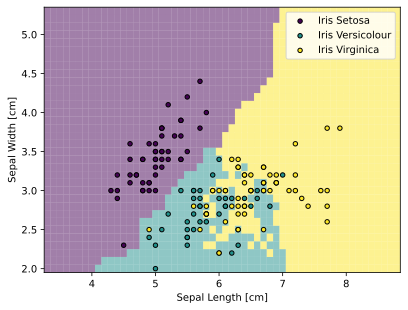

In [17]:
K = 3
step = 0.1

xx, yy = np.meshgrid(np.arange(X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1, step),
                     np.arange(X.iloc[:, 1].min(), X.iloc[:, 1].max() + 1, step))

ypred = []
for xtest in np.array([xx.ravel(), yy.ravel()]).T:
    ypred.append(KNN(K, X, y, xtest))

fig, ax = plt.subplots()

cmap = plt.cm.viridis
norm = plt.Normalize(y.min(), y.max())

ax.pcolormesh(xx, yy, np.array(ypred).reshape(xx.shape), cmap=cmap, alpha=0.5)
for i, iris_class in enumerate(iris_classes):
    mask = y == i
    ax.scatter(X.loc[mask].iloc[:, 0], X.loc[mask].iloc[:, 1], edgecolor='k', s=20, label=iris_class, cmap=cmap, norm=norm, c=y[mask])
ax.set(xlabel='Sepal Length [cm]', ylabel='Sepal Width [cm]')
ax.legend()